---
# <center>Note: Due to issues with TensorFlow module installation in Jupyter notebook, we used <font color='red'>Google Colaboratory</font> for creating a neural network model<center>
---

In [1]:
####### Import Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from collections import Counter
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import load_breast_cancer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from matplotlib.ticker import FuncFormatter

In [2]:
####### Import Packages for Neural Networks
import keras
from keras.models import Sequential          # sequential module
from keras.layers import Dense               # dense module for hidden layers
from keras.layers import LeakyReLU,PReLU,ELU # activation functions
from keras.layers import Dropout             # dropout Layer
from tensorflow.keras.utils import plot_model

In [3]:
# Import data (imported as a dictionary)
data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [4]:
###### Load the dataset into a dataframe
# Read the dataframe, first using the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add a target column, and fill it with the target data
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Removal of highly correlated features

In [5]:
corr = df.corr().abs().round(2)  # map features to their absolute Pearson's correlation values
np.fill_diagonal(corr.values, 0) # set self correlation values as zero
corr_cols = corr.max().sort_values(ascending=False) # find max correlation per feature and sort the resulting array in ascending order
display(corr_cols[corr_cols >= 0.9]) # display the highly correlated features

mean radius             1.00
mean perimeter          1.00
worst radius            0.99
mean area               0.99
worst perimeter         0.99
worst area              0.98
perimeter error         0.97
radius error            0.97
area error              0.95
mean concave points     0.92
mean concavity          0.92
worst concave points    0.91
mean texture            0.91
worst texture           0.91
dtype: float64

In [6]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [7]:
selected_columns = df.columns[columns]
selected_columns.shape
# 20 features were selected (plus the target variable)

(21,)

In [8]:
data_kept = df[selected_columns] ## the dataset has only those columns with correlation less than 0.9
pd.set_option('display.max_columns', None)
print(data_kept.shape)
data_kept.head(4)

(569, 21)


,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst smoothness,worst compactness,worst concavity,worst symmetry,worst fractal dimension,target
0,17.99,10.38,0.11840,0.27760,0.3001,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890,0
1,20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902,0
2,19.69,21.25,0.10960,0.15990,0.1974,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758,0
3,11.42,20.38,0.14250,0.28390,0.2414,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300,0


### Data Splitting

In [9]:
# split data in subsets in a stratified manner (sss: stratified shuffle split)
test_sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=13)
test_sss
# Set a seed (random_state = 0) to get the same "random" shuffle every time

StratifiedShuffleSplit(n_splits=10, random_state=13, test_size=0.15,
            train_size=None)

In [10]:
# Separate response from predictors
x = data_kept.iloc[:,:-1] # store the feature data (x)
y = data_kept.iloc[:,-1:] # store the target data (y)
x.head(3)

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst smoothness,worst compactness,worst concavity,worst symmetry,worst fractal dimension
0,17.99,10.38,0.11840,0.27760,0.3001,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890
1,20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902
2,19.69,21.25,0.10960,0.15990,0.1974,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758


In [11]:
# splitting in training and test sets
x_train, x_test, y_train, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(x, y): 
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [12]:
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (483, 20)
y_train shape: (483, 1)

x_test shape: (86, 20)
y_test shape: (86, 1)


---
## <center><ins>**Artificial Neural Network (ANN)**</ins></center>
---

Regarding the neural networks classification model, we used the standardized data as they were sensitive to the variance in the data. We decided to use an ANN model which is a sequential model meaning that each layer that we add per line will use as input the output of the former layer added to the model

### Creating Layers
We started by creating the three types of layers:
* Input layer
* Hidden layer
* Output layer

<b><ins>Dropout Layer</ins></b>

We also decided to check the effect from the addition of the dropout layer to our model.

* [Dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks)) is regularization technique to avoid overfitting (increase the validation accuracy) thus increasing the generalizing power.

* The [idea behind dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) is that at each training stage, individual nodes are either "dropped out" of the network with probability $p$ or kept with probability $1 - p$, so that a reduced network is left.

* Incoming and outgoing edges to a dropped-out node are also removed and only the reduced network is trained.

* After training for the epoch the removed nodes are then reinserted into the network with their original weights.

* At test time, no dropout is performed. Instead, the layer's output values are scaled out by $p$ to compensate for the fact that there are more neurons active than in training.

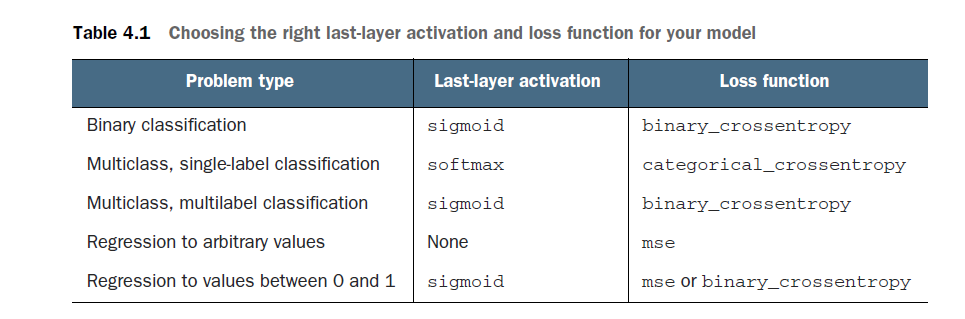


In [13]:
# => 3-layer NN
print('Build model...')

######## Initialising the model
model = Sequential()
######## Create layers of the neural network
# First hidden layer
model.add(Dense(units=10, activation='relu', input_dim=20))
model.add(Dropout(0.1)) # Adding dropout to prevent overfitting
# Second hidden layer
model.add(Dense(units=10, activation='relu', input_dim=20))
model.add(Dropout(0.1))  # Adding dropout to prevent overfitting
# Output layer: Since we have a binary classification scheme, we select a single neuron with sigmoid activation.
model.add(Dense(units=1, activation='sigmoid', input_dim=20)) # output layer

Build model...


In [14]:
# Summary of layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


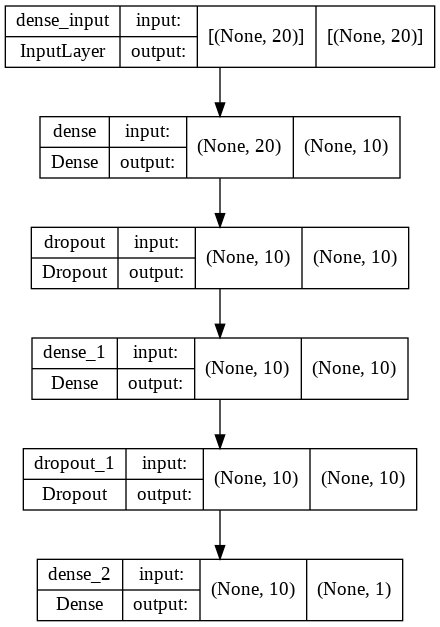

In [15]:
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

### Build network and train it untill validation loss reduces (EarlyStopping)


In [16]:
######## Compiling our model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
######## Fitting our model to the training set
scaler = StandardScaler()

# Setting model hyperparameters
num_epochs = 10  # we iterate up to 10 times over the entire training set 
batch_size = 32

model.fit(scaler.fit_transform(x_train), y_train, epochs=num_epochs, batch_size=batch_size, 
          shuffle=True, validation_data=(scaler.fit_transform(x_test), y_test))

Epoch 1/10
16/16 [==============================] - 2s 16ms/step - loss: 0.6764 - accuracy: 0.6087 - val_loss: 0.5702 - val_accuracy: 0.7326
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5794 - accuracy: 0.7060 - val_loss: 0.4954 - val_accuracy: 0.8140
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 0.5105 - accuracy: 0.7867 - val_loss: 0.4384 - val_accuracy: 0.8721
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 0.4543 - accuracy: 0.8551 - val_loss: 0.3909 - val_accuracy: 0.9186
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 0.4125 - accuracy: 0.8758 - val_loss: 0.3543 - val_accuracy: 0.9186
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.3754 - accuracy: 0.8613 - val_loss: 0.3250 - val_accuracy: 0.9186
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.3491 - accuracy: 0.8737 - val_loss: 0.3009 - val_accuracy: 0.9186
Epoch 8/10
16/16 [=

### Batch size & Epochs
* Batch size defines number of samples that going to be propagated through the network.

* An Epoch is a complete pass through all the training data.

<center><ins>Explanation of parameters usefulness in the procedure:</ins></center>

* Epoch - A single pass over the entire training dataset.
* Mini-batch - Number of samples to pass thru the model before performing a single update of its weights.
* Iterations - Number of required mini-batches to complete a full epoch.

<ins>Comment1:</ins> Iterations per epoch are set automatically according to how many training examples there are present. 

<ins>Comment2:</ins> If we want to change the number of passes over the data, we use the epoch number.


&rarr; In general: 
> Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent. The models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge.

&rarr; In our case: 
> We have a relative training small dataset, so we would probably be safe using a batch size of 32, which is pretty standard.

In [18]:
# Predicting the test set results
y_pred = model.predict(scaler.transform(x_test))

The predictions above contained the different values , so we decided to use a threshold value in order to convert the predicting values into values like True, False.

In [19]:
# Converting values
y_pred = (y_pred > 0.5)
print(y_pred[:5])

[[False]
 [ True]
 [ True]
 [ True]
 [False]]


In [20]:
# Evaluate the trained model on the test set and store on score variable
score = model.evaluate(
    scaler.transform(x_test), # features
    y_test,                   # labels
    batch_size=batch_size,    # batch size
    verbose=1                 # the most extended verbose
)

print('\nTest categorical_crossentropy: {:.4f}'.format(score[0]))
print('\nTest accuracy: {:.2f} %'.format(score[1]*100))

3/3 [==============================] - 0s 4ms/step - loss: 0.2446 - accuracy: 0.9419

Test categorical_crossentropy: 0.2446

Test accuracy: 94.19 %


In [21]:
# Confusion Matrix of the predicted values
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[29  3]
 [ 2 52]]


In [22]:
print('Accuracy of ANN classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

print("\nClassification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, y_pred)))

### print(classification_report(y_test, predictions))

Accuracy of ANN classifier on test set: 0.94

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f816ea6d190>:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.95      0.96      0.95        54

    accuracy                           0.94        86
   macro avg       0.94      0.93      0.94        86
weighted avg       0.94      0.94      0.94        86




In [23]:
auc = metrics.roc_auc_score(y_test, y_pred)
print('Area Under Curve (AUC) is equal to: {:.3f}'.format(auc))

Area Under Curve (AUC) is equal to: 0.935


# <center>Conclusions (Neural Networks)</center>

For identifying the best hyper-parameters for which our neural network model presented the best results, we could for example:

* Add extra layers with different dimensionality of the output space or check different values of the layers' dimensionality

* Check different kernel size

* Check different batch sizes and number of epochs

* Check the effect from using different values in the dropout layer